In [3]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')

In [5]:
def convert_int2onehot(gt_idx_list, n_class=10):
    batch_size=len(gt_idx_list)
    gt_onehot = torch.zeros((batch_size, n_class))
    gt_onehot[torch.arange(batch_size), gt_idx_list] = 1
    return gt_onehot

In [45]:
convert_int2onehot([1,2,3], 5)

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])

In [47]:
# Note - broadcasting
convert_int2onehot([[1],[2]], 10) 
# gt_onehot[[0,1], [[1],[2]]] is broadcasted to gt_onehot[[0,1],[[1,1],[2,2]]]

tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])

# Regression Loss

## MSE Loss

In [48]:
def generate_regression(batch_size=16):
    return torch.rand(batch_size), torch.rand(batch_size)

In [49]:
predicted, gt = generate_regression()
print('predicted.shape ==', predicted.shape, 'ground_truth ==', gt.shape)

predicted.shape == torch.Size([16]) ground_truth == torch.Size([16])


In [50]:
loss = nn.MSELoss(reduction = 'mean')
loss(predicted, gt) # return scalar

tensor(0.1721)

In [51]:
loss = nn.MSELoss(reduction = 'none')
loss(predicted, gt) # vector with 16 (batch size) elements

tensor([6.1403e-03, 9.7461e-05, 4.2878e-01, 1.8997e-02, 4.7067e-01, 2.2248e-01,
        5.0675e-01, 1.2691e-01, 3.3142e-02, 1.2032e-01, 1.4247e-02, 5.1327e-01,
        6.2677e-03, 1.0802e-01, 2.8360e-02, 1.4861e-01])

In [52]:
torch.mean(loss(predicted, gt)) # same with the loss function with reduction = 'mean'

tensor(0.1721)

## MAE Loss

In [53]:
loss = nn.L1Loss(reduction='mean')
loss(predicted, gt)

tensor(0.3396)

## Huber Loss

In [54]:
loss = nn.HuberLoss(reduction='mean')
loss(predicted, gt)

tensor(0.0860)

In [58]:
N=100
y_pred = np.linspace(-3, 3, N)
y_pred = torch.Tensor(y_pred)
y_true = torch.zeros(N)

l1_loss_fn = nn.L1Loss(reduction="none")
l1_list = l1_loss_fn(y_pred, y_true)

mse_loss_fn = nn.MSELoss(reduction="none")
mse_list = mse_loss_fn(y_pred, y_true)

huber_loss_fn = nn.HuberLoss(reduction="none")
huber_list = huber_loss_fn(y_pred, y_true)


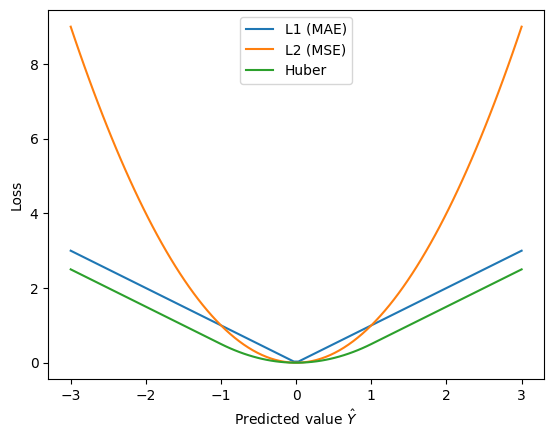

In [60]:
plt.figure()
plt.plot(y_pred, l1_list.numpy(), label='L1 (MAE)')
plt.plot(y_pred, mse_list.numpy(), label='L2 (MSE)')
plt.plot(y_pred, huber_list.numpy(), label='Huber')
plt.legend()
plt.xlabel(r"Predicted value $\hat{Y}$")
plt.ylabel('Loss')
plt.show()

From above, we can figure out that huber loss function is similar with L2 function when error is small. But when if error is large, huber loss is similar with L1 function. Hence, huber loss enhances the model's training speed when error is small, and robust to outliers (or anomalies) when error is quite large. 

# Classification Loss

In [61]:
def generate_class_int(batch_size=16, n_class=10):
    pred = torch.nn.Softmax()(torch.rand(batch_size, n_class)) # pred shape: (batch_size, n_class)
    gt = torch.argmax(torch.rand(batch_size, n_class), dim=1) # gt shape: (batch_size, )
    return pred, gt

In [92]:
def generate_class_onehot(batch_size=16, n_class=10):
    pred = torch.nn.Softmax()(torch.rand(batch_size, n_class))
    gt = torch.zeros(batch_size, n_class)
    gt[torch.arange(batch_size), torch.argmax(torch.rand(batch_size, n_class), dim=1)] = 1.
    return pred, gt

In [93]:
predicted, gt = generate_class_int()

In [94]:
predicted.shape

torch.Size([16, 10])

In [95]:
gt.shape

torch.Size([16])

## Cross Entropy Loss
- when using `nn.CrossEntropyLoss`, input shape must be smaller than target shape by one dimension. For example, input.shape == (batch_size, num_class) and target.shape == (batch_size,)
- target must be long type integer.

In [125]:
predicted, gt = generate_class_int()
loss = nn.CrossEntropyLoss(reduction='mean')
loss(predicted, gt)

tensor(2.3025)

In [126]:
loss = nn.CrossEntropyLoss(reduction='none')
loss(predicted, gt)

tensor([2.2691, 2.3346, 2.3175, 2.2925, 2.2977, 2.2652, 2.2811, 2.3215, 2.3307,
        2.2873, 2.2816, 2.2951, 2.3142, 2.3319, 2.3004, 2.3192])

- when using `nn.BCELoss`, input shape and target shape must be equal.
- input must be normalized into 0 ~ 1. 
- target value must be also 0 ~ 1 and float type.

In [139]:
predicted, gt = generate_class_onehot()
loss = nn.BCELoss(reduction='mean')
loss(predicted, gt)

tensor(0.3365)

- `nn.BCEWithLogitsLoss` is Sigmoid layer + nn.BCELoss
- if we forward pass Sigmoid and BCELoss separately, there may be a numerical instability
- `nn.BCEWithLogitsLoss` is numerically stable
- Hence, we should skip sigmoid layer when using `nn.BCEWithLogitsLoss`

In [140]:
predicted = 10 * predicted

In [141]:
loss = nn.BCEWithLogitsLoss(reduction = 'mean')
loss(predicted, gt)

tensor(1.2283)

In [142]:
loss = nn.BCELoss(reduction="mean")
loss(torch.nn.Sigmoid()(predicted), gt)

tensor(1.2283)

## L1 Loss

In [143]:
predicted, gt = generate_class_onehot()
loss = nn.L1Loss(reduction='mean')
loss(predicted, gt)

tensor(0.1789)

## KL Divergence Loss

In [144]:
predicted, gt = generate_class_onehot()
loss = nn.KLDivLoss(reduction='mean')
loss(predicted, gt)

tensor(-0.0097)